# Geospatial Analysis Example

Let's take a look at a data set with a geospatial element: DC Urban Forestry Street Trees Data

http://opendata.dc.gov/datasets/urban-forestry-street-trees


Let's have a simple question, in which neighborhood of DC can one find the most cherry trees?

## Download the Data

In [1]:
import requests

csv_url = 'https://opendata.arcgis.com/datasets/f6c3c04113944f23a7993f2e603abaf2_23.csv'

def download_file(url, filename):
    """Downloads a file from a url onto your computer"""
    response =  requests.get(url)
    with open(filename, 'wb') as f:
        f.write(response.content)

download_file(csv_url, '../data/Urban_Forestry_Street_Trees.csv')

In [7]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

from sklearn import preprocessing

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
df = pd.read_csv('../data/Urban_Forestry_Street_Trees.csv')
df['counter'] = 1

In [9]:
# Look at the Data
df.head(3)

,X,Y,OBJECTID,FACILITYID,VICINITY,WARD,TBOX_L,TBOX_W,WIRES,CURB,...,TRRS,WARRANTY,FAM_NAME,CREATED_USER,CREATED_DATE,EDITEDBY,LAST_EDITED_USER,LAST_EDITED_DATE,GENUS_NAME,counter
0,-76.950325,38.891952,18046536,21625-390-3001-0008-000,3828 BLAINE ST NE,7.0,99.0,5.0,Low Voltage,Permanent,...,NaN,Unknown,Aceraceae,NaN,NaN,jburckle,SDE,2014-11-26T01:46:33.000Z,Acer,1
1,-77.049221,38.911571,18046537,15960-220-3001-0093-000,2202 MASSACHUSETTS AVE NW,2.0,12.0,6.0,None,Permanent,...,NaN,Unknown,Tiliaceae,NaN,NaN,sbanua,ufaarborist,2016-09-21T12:58:48.000Z,Tilia,1
2,-76.978288,38.896086,18046538,23133-180-3005-0174-000,1823 E ST NE,6.0,99.0,3.0,None,Permanent,...,NaN,Unknown,Aceraceae,NaN,NaN,ufaarborist,SDE,2014-11-26T01:46:33.000Z,Acer,1


# Let's look at the Common Names of the Trees to Get a sense of the distribution

In [10]:
df.groupby('CMMN_NM').counter.sum().reset_index().sort_values('counter', ascending=False)[:20]

,CMMN_NM,counter
141,Red maple,12659
197,Willow oak,9409
129,Pin oak,9403
124,Other (See Notes),7001
174,Sugar maple,6363
5,American elm,5920
142,Red oak,5901
96,Japanese zelkova,5159
107,London plane tree,4495
118,Norway maple,4431


## All Cherry Trees are Part of the Prunus Family
### Let's just select that family

In [11]:
limited_df = df[ (df.GENUS_NAME=='Prunus') ]

# encode the names because computers do not understand english
genus_names = limited_df.GENUS_NAME.unique()
genus_le = preprocessing.LabelEncoder()
genus_le.fit(genus_names)
limited_df['genus_code'] = genus_le.transform(limited_df.GENUS_NAME) 

In [12]:
limited_df.CMMN_NM.value_counts()

Cherry                2180
Kwanzan cherry        1906
Yoshino cherry        1510
Chokecherry           1487
Cherry (Snowgoose)    1436
Okame cherry           519
Purple leaf plum       404
Japanese Apricot        32
Lilac                    2
Yellowwood               2
Chinese pistachio        2
Red maple                1
Crape myrtle             1
Name: CMMN_NM, dtype: int64

## Let's Plot it to Take a Quick look

In [13]:
featured = ['X', 'Y']
features = limited_df[featured].as_matrix()
y = limited_df.genus_code.values

In [14]:
import mplleaflet

sample = limited_df.sample(1000)
plt.scatter(sample['X'], sample['Y'], c=sample['genus_code'])

mplleaflet.display()

# Let's Do A Kernel Density Map To Get a Better Sense 

First, we need to get shapefiles from the District of Columbia Open Data Portal

http://opendata.dc.gov/datasets/neighborhood-clusters/data

We'll use the seaborn kdeplot for this
http://seaborn.pydata.org/generated/seaborn.kdeplot.html#seaborn.kdeplot

In [15]:
# Download It
shape_url = 'https://opendata.arcgis.com/datasets/f6c703ebe2534fc3800609a07bad8f5b_17.zip'
file_loc = '../data/Neighborhood_Clusters.zip'
download_file(csv_url, file_loc)

In [16]:
import geopandas as gpd
# Like pandas but with tools for geospatial data types

In [17]:
dc = gpd.read_file("../data/unzipped/Neighborhood_Clusters/Neighborhood_Clusters.shp")
# dc.plot()

In [18]:
import shapely
# geospatial library
# Manipulation and analysis of geometric objects in the Cartesian plane.

tree_locations = gpd.GeoDataFrame(limited_df, geometry=limited_df.apply(
        lambda srs: shapely.geometry.Point(srs['X'], srs['Y']), axis='columns'
    ))

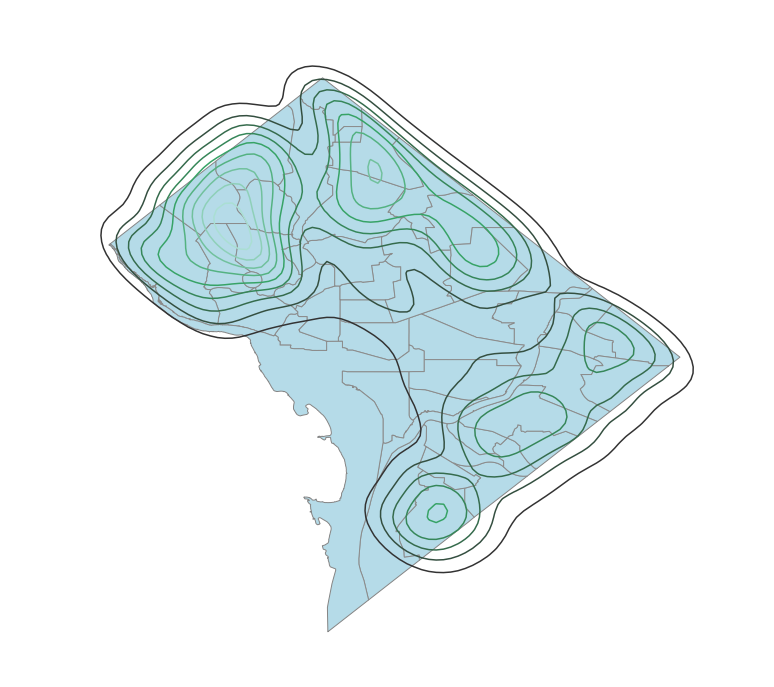

In [19]:
import seaborn as sns
ax = dc.plot(figsize=(20, 12), color='#ADD8E6', edgecolor='gray')

dc.plot(ax=ax, alpha=0.1, linewidth=0.25, color='white')
sns.kdeplot(data=tree_locations.apply(lambda srs: pd.Series({'x': srs.geometry.x, 'y': srs.geometry.y}), axis='columns'), ax=ax,
            alpha=1)
ax.set_axis_off()

# Okay, we have a general sense. Let's drill down to the neighbor level

In [20]:
# Lets assign a neighborhood to each tree

import numpy as np

def assign_neighborhood_tract(tree):
    bools = [geom.contains(tree['geometry']) for geom in dc['geometry']]
    if True in bools:
        return dc.iloc[bools.index(True)]['NAME']
    else:
        return np.nan

In [21]:
# Assign each tree to a neighbor hood tract
tree_locations['neighborhood'] = tree_locations.apply(assign_neighborhood_tract, axis='columns')

In [22]:
neighbor_count =  tree_locations.groupby('neighborhood').counter.sum().reset_index()
neighbor_count = neighbor_count.sort_values('counter', ascending=False).reset_index(drop=True)

In [31]:
# dc.head()

In [24]:
# Add the 
neighbor_counts =  dict(zip(neighbor_count.neighborhood, neighbor_count.counter))

In [25]:
dc['tree_count'] = dc['NAME'].map(neighbor_counts)

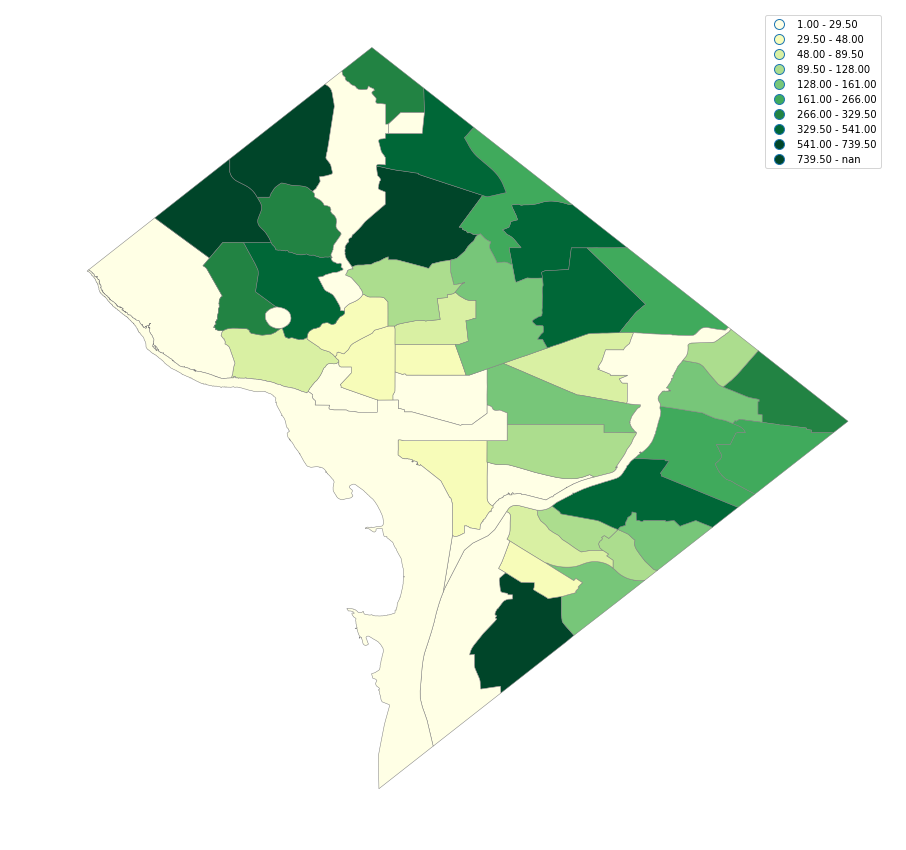

In [33]:
f = plt.figure(figsize=(15, 15))
ax = f.gca()
kw = dict(column='tree_count', k=10, cmap='YlGn', alpha=1, legend=True, edgecolor='gray', linewidth=0.5)
dc.plot(scheme='QUANTILES', ax=ax, **kw)
ax.set_axis_off()

This type of map is, as was mentioned earlier, known as a choropleth. It's a ubiquitious classic of the genre. The darker the shading, the more Cherry Trees in that neighborhood.

Aside from a variety of visual parameters, we specified three important ones. column=tree_count told geopandas which columns to plot data from. scheme=QUANTILES is which "bucketing" system you want to plot with: in this case we specified quantiles, which splits the data into bins equal in number, albiet not in size. Finally, k tells geopandas how many bins we want.

The trouble with this map, however, is that it doesn't take into account the size of the neighborshoods. If our census tract is bigger than average, it'll naturally contain more homes, and, all else being equal, more Cherry Trees.

This is a classical mapmaking fallacy. 

In our case we'll fix it by figuring out Cherry Tree density per square kilometer, not just the raw number, and plot that.

In [27]:
# Let's calculate trees per square kilometer
dc['tree_density'] = (dc['tree_count'] / dc['geometry'].to_crs({'init': 'epsg:3395'}).map(lambda p: p.area / 10**6)).fillna(0)

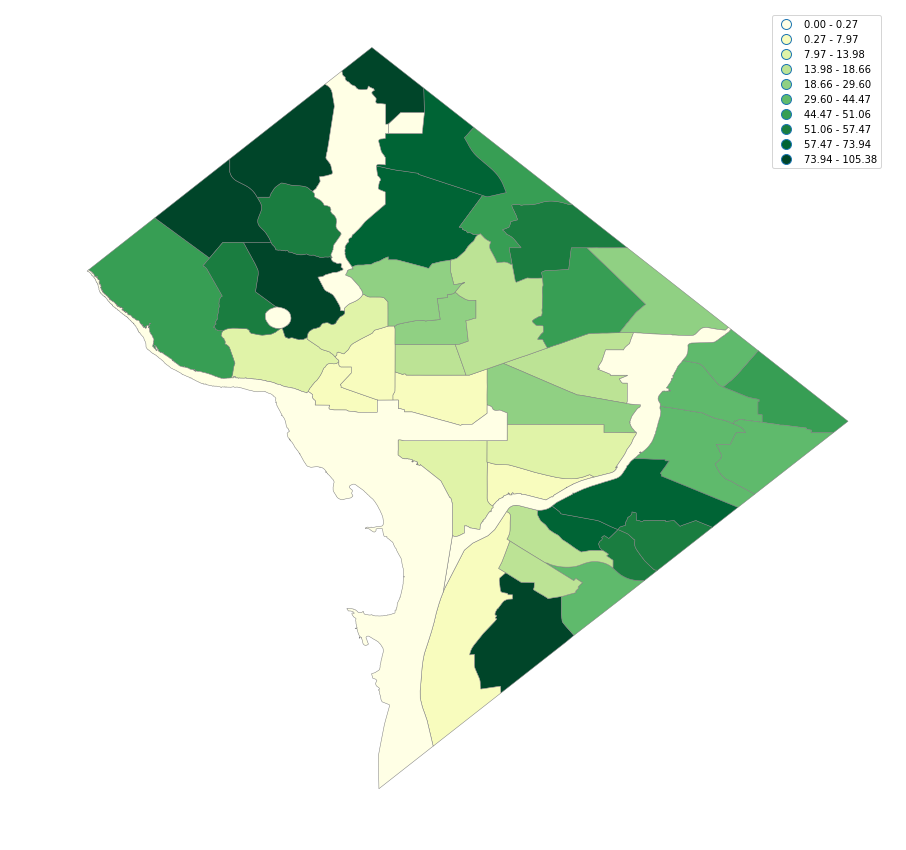

In [34]:

f = plt.figure(figsize=(15, 15))
ax = f.gca()
kw = dict(column='tree_density', k=10, cmap='YlGn', alpha=1, legend=True, edgecolor='gray', linewidth=0.5)
dc.plot(scheme='QUANTILES', ax=ax, **kw)
ax.set_axis_off()


In [29]:
dc[['NBH_NAMES', 'tree_count', 'tree_density']].sort_values('tree_count', ascending=False).head(10)

,NBH_NAMES,tree_count,tree_density
17,"Spring Valley, Palisades, Wesley Heights, Foxh...",751.0,50.169324
21,"Friendship Heights, American University Park, ...",728.0,105.377720
0,"Congress Heights, Bellevue, Washington Highlands",700.0,87.144851
20,"Brightwood Park, Crestwood, Petworth",698.0,65.147266
25,"Hawthorne, Barnaby Woods, Chevy Chase",649.0,79.558944
37,"Cleveland Park, Woodley Park, Massachusetts Av...",541.0,82.392888
29,"Twining, Fairlawn, Randle Highlands, Penn Bran...",534.0,65.866678
23,"Takoma, Brightwood, Manor Park",505.0,68.325778
34,"Brookland, Brentwood, Langdon",403.0,50.795136
18,"North Michigan Park, Michigan Park, University...",343.0,52.293525


In [30]:
dc[['NBH_NAMES', 'tree_count', 'tree_density']].sort_values('tree_density', ascending=False).head(10)

,NBH_NAMES,tree_count,tree_density
21,"Friendship Heights, American University Park, ...",728.0,105.377720
0,"Congress Heights, Bellevue, Washington Highlands",700.0,87.144851
24,"Colonial Village, Shepherd Park, North Portal ...",316.0,85.242016
37,"Cleveland Park, Woodley Park, Massachusetts Av...",541.0,82.392888
25,"Hawthorne, Barnaby Woods, Chevy Chase",649.0,79.558944
23,"Takoma, Brightwood, Manor Park",505.0,68.325778
29,"Twining, Fairlawn, Randle Highlands, Penn Bran...",534.0,65.866678
20,"Brightwood Park, Crestwood, Petworth",698.0,65.147266
26,Historic Anacostia,128.0,58.104577
19,"North Cleveland Park, Forest Hills, Van Ness",305.0,57.471960
